# Training Model MERA 8 Qubits
##### Comparing different loss functions
<a id="0"></a> <br>
1. [Data Preparation](#1)
2. [Model](#2)
3. [Experiment 1](#3)
    a. [Training](#4)
    b. [Test Accuracy](#5)
4. [Experiment 2](#6)
    a. [Training](#7)
    b. [Test Accuracy](#8)
4. [Experiment 3](#9)
    a. [Training](#10)
    b. [Test Accuracy](#11)
5. [Experiment 4](#12)
    a. [Training](#13)
    b. [Test Accuracy](#14)

Data Preparation:
* image_limit: `3,000`
* cropping parameters: `vertical_start_split=0.3, vertical_end_split=1.0,horizontal_start_split=0.25, horizontal_end_split=0.75`
* image size to resize: `(64, 64)`
* autoencoder component: `256`
* split data to train and validation - `train_ratio=0.8`

| Experiment | Training set         | Validation set       | Test set             | Cost function      | Epoch | Batch | Learning rate | Training time | Val_accuracy | Test_accuracy |
|------------|-----------------------|----------------------|----------------------|--------------------|-------|-------|----------------|---------------|--------------|---------------|
| 1          | [2393 2407] | [303 297]  | [304 296] | Cross-Entropy Loss | 200    | 128    | 0.05           | 4.064 h         | 88.17%       | 86.0%        |
| 2          | [2393 2407] | [303 297]  | [304 296] | Exponential Loss | 200   | 128   | 0.05           | 4.059 h           | 92.67%       | 89.83%          |
| 3          | [2393 2407] | [303 297]  | [304 296] | Focal Loss(gamma=1) | 200   | 128    | 0.05           | 4.41 h         | 89.33%       | 86.0%        |
| 4          | [2393 2407] | [303 297] | [304 296] | Focal Loss(gamma=2) | 200  | 128    | 0.05           | 4.52 h         | 92.33%          | 80.83%           |


In this notebook we have made 4 experiments for binary image classification using MERA architecture quantum tensor network. The exponential loss emerged as the winer providing the best validation and test_accuracy. All experiments used same parameters, dataset, batch size and learning rate but different loss functions. The autoencoder was used to reduce the values in one image from 64*64=4096 to 256.

<a id="1"></a>
### Data Preparation

In [1]:
from Modules.ImageLoader import ImageLoader
loader = ImageLoader(
    json_paths=['C:/Users/lenovo/Downloads/archive(3)/al5083/al5083/train/train.json', 'C:/Users/lenovo/Downloads/archive(3)/al5083/al5083/test/test.json'],
    data_dirs=['C:/Users/lenovo/Downloads/archive(3)/al5083/al5083/train', 'C:/Users/lenovo/Downloads/archive(3)/al5083/al5083/test'],
    image_size=(64, 64)
)

In [2]:
all_data = loader.load_images(image_limit=3000,vertical_start_split=0.3, vertical_end_split=1.0,horizontal_start_split=0.25, horizontal_end_split=0.75)

Images loaded: 17100, Current label: 5, Total per label: {0: 3000, 1: 2134, 2: 3000, 3: 3000, 4: 3000, 5: 2966}

Total images loaded : 17134


Get balanced dataset for binary classification.
Class 1 is made of 5 types of defective images.

In [3]:
from Modules.Utils import reduce_dataset_to_2_classes
new_all_data = reduce_dataset_to_2_classes(all_data, class_0_count=3000, other_classes_count=600)

Shuffles the dataset and separates it into flattened features and labels.

In [4]:
import Modules.Utils
X_set,Y_set = Modules.Utils.prepare_data(new_all_data)

Every image is reshaped from flatten to (64, 64, 1)

In [5]:
import numpy as np
for i in range(len(X_set)):
    X_set[i] = np.reshape(X_set[i], (64, 64, 1))

Split train data to train set and validation set.

In [8]:
from Modules.Utils import split_data_into_train_val_test

X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data_into_train_val_test(X_set, Y_set, train_ratio=0.8, val_ratio=0.1,test_ratio=0.1)

Y_train: Values: [0 1] Counts: [2393 2407]
Y_val: Values: [0 1] Counts: [303 297]
Y_test: Values: [0 1] Counts: [304 296]


Training set:

In [9]:
import numpy as np
values, counts = np.unique(Y_train, return_counts=True)
print(values)
print(counts)

[0 1]
[2393 2407]


Validation set:

In [10]:
import numpy as np
values, counts = np.unique(Y_val, return_counts=True)
print(values)
print(counts)

[0 1]
[303 297]


Test set:

In [11]:
import numpy as np
values, counts = np.unique(Y_test, return_counts=True)
print(values)
print(counts)

[0 1]
[304 296]


### autoencoder

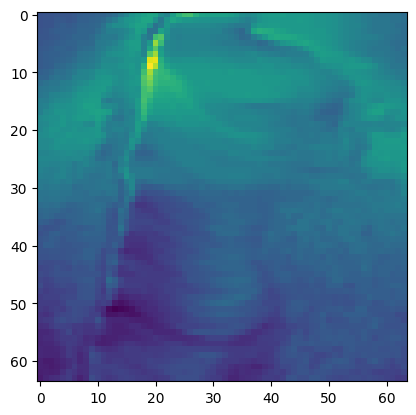

In [16]:
import matplotlib.pyplot as plt
plt.imshow(X_train[3600])

Normalize the image

In [17]:
X_train = np.array(X_train).astype('float32') / 255.
X_test = np.array(X_test).astype('float32') / 255.
X_val = np.array(X_val).astype('float32') / 255.

In [18]:
import keras
from keras import layers, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D
from keras import ops
import tensorflow as tf

Build, compile and fit the autoencoder.

In [23]:
encoder_inputs = keras.Input(shape=(64, 64, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(4096, activation="relu")(x)
encoder = layers.Dense(256, activation="relu")(x)

x = layers.Dense(8* 8 * 64, activation="relu")(encoder)
x = layers.Reshape((8, 8, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
decoder = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

In [24]:
model = Model(encoder_inputs, decoder)
model.compile(optimizer='adam', loss='mean_squared_error')

In [25]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4096)                │      67,112,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │       1,048,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 4096)                │       1,052,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 64, 64, 16)          │           4,624 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 64, 64, 1)           │             145 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,293,441 (264.33 MB)

 Trainable params: 69,293,441 (264.33 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.fit(np.array(X_train), np.array(X_train),
                epochs=20,
                batch_size=8,
                shuffle=True, validation_data=(np.array(X_test), np.array(X_test)))

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 351s 548ms/step - loss: 0.0121 - val_loss: 0.0042
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 322s 536ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 321s 536ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 325s 542ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 342s 569ms/step - loss: 0.0011 - val_loss: 9.7701e-04
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 338s 563ms/step - loss: 9.3677e-04 - val_loss: 9.3970e-04
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 329s 548ms/step - loss: 8.8012e-04 - val_loss: 8.2238e-04
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 325s 541ms/step - loss: 7.9388e-04 - val_loss: 7.8898e-04
Epoch 9/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 321s 534ms/step - loss: 7.4003e-04 - val_loss: 7.2554e-04
Epoch 10/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 327s 546ms/step - loss: 7.1333e-04 - val_loss: 6.9816e-04
Epoch 11/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 324s 540ms/ste

In [27]:
encod = keras.Model(encoder_inputs, encoder)
encoded_X_train = encod.predict(X_train)
encoded_X_val = encod.predict(X_val)
encoded_X_test = encod.predict(X_test)

150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


<a id="2"></a>
### Model

Block looks like
![circuit](./Images/MERA_block_1.png)

(<Figure size 1400x300 with 1 Axes>, <Axes: >)

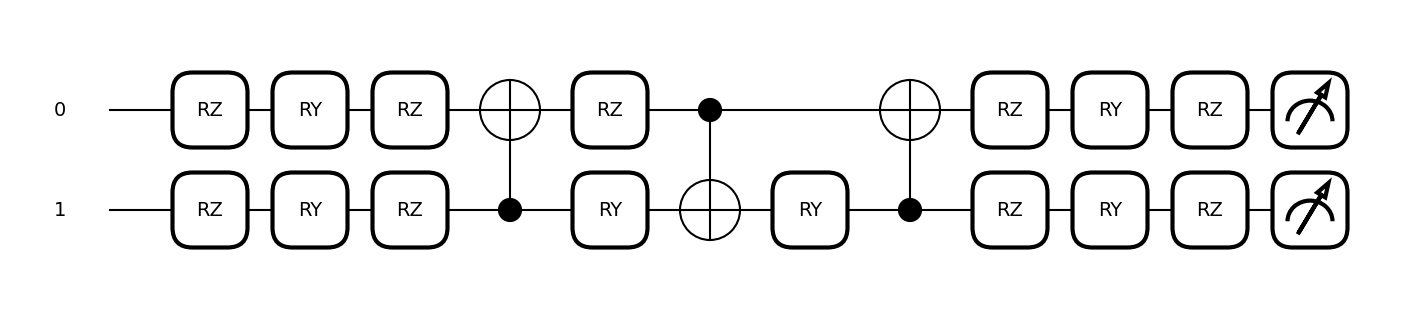

In [30]:
import pennylane as qml
from pennylane import numpy as np
def block(weights, wires):
    qml.RZ(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[0])
    qml.RZ(weights[2], wires=wires[0])

    qml.RZ(weights[3], wires=wires[1])
    qml.RY(weights[4], wires=wires[1])
    qml.RZ(weights[5], wires=wires[1])

    qml.CNOT(wires=[wires[1], wires[0]])

    qml.RZ(weights[6], wires=wires[0])
    qml.RY(weights[7], wires=wires[1])

    qml.CNOT(wires=[wires[0], wires[1]])

    qml.RY(weights[8], wires=wires[1])

    qml.CNOT(wires=[wires[1], wires[0]])

    qml.RZ(weights[9], wires=wires[0])
    qml.RY(weights[10], wires=wires[0])
    qml.RZ(weights[11], wires=wires[0])

    qml.RZ(weights[12], wires=wires[1])
    qml.RY(weights[13], wires=wires[1])
    qml.RZ(weights[14], wires=wires[1])

dev= qml.device('default.qubit',wires=range(2))
@qml.qnode(dev)
def circuit_block(f, template_weights):
    block(template_weights,wires=[0,1])
    return qml.probs(wires = [0, 1])

weights = np.random.random(size=[15, 1])
qml.draw_mpl(circuit_block, expansion_strategy="device")(encoded_X_train[0][0:4], weights)

MERA architecture looks like:

![Mera circuit](./Images/MERA_1.png)

(<Figure size 9600x900 with 1 Axes>, <Axes: >)

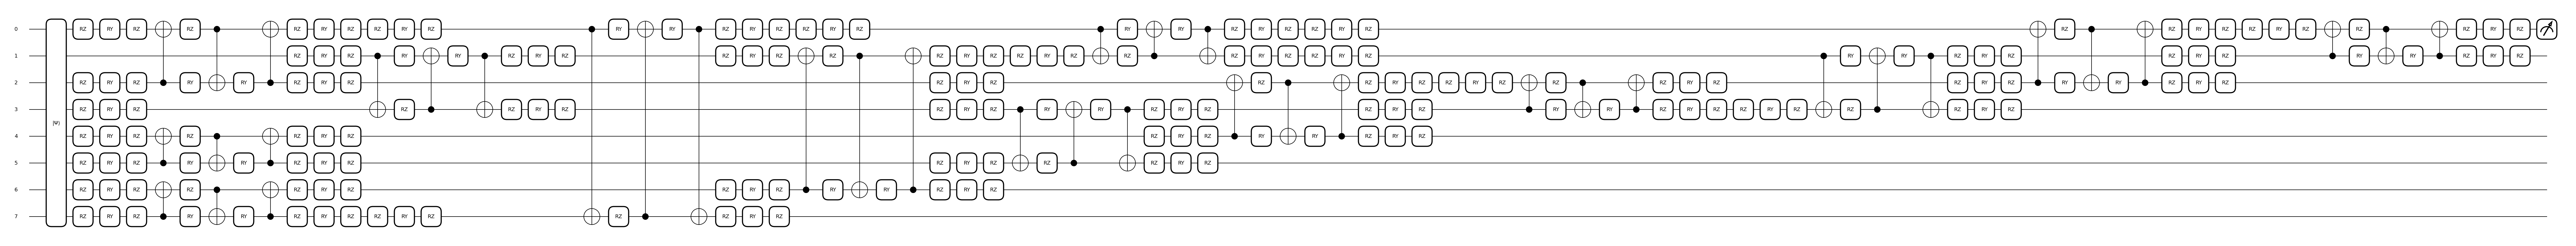

In [31]:
n_wires = 8
n_block_wires = 2
n_params_block = 15
n_blocks = qml.MERA.get_n_blocks(range(n_wires),n_block_wires)


dev= qml.device('default.qubit',wires=range(n_wires))
@qml.qnode(dev)
def circuit_MERA(f, template_weights):
    qml.AmplitudeEmbedding(features=f, wires=range(n_wires), normalize=True)
    qml.MERA(range(n_wires),n_block_wires,block, n_params_block, template_weights)
    return qml.probs(wires = [0])


weights = np.random.random(size=[n_blocks, 15])
qml.draw_mpl(circuit_MERA, expansion_strategy="device")(encoded_X_train[0], weights)

##### FL: Focal Loss
\begin{aligned} FL(p_t) = - (1 - p_t)^\gamma \log(p_t) \end{aligned}

##### BCE: Binary Cross Entropy
\begin{aligned} Loss = - \sum_{i=1}^{\text{output size}} y_i \cdot \log \hat{y}_i \end{aligned}

##### Exponential Loss
\begin{aligned} loss=\sum _i{(1+10e^{7p_i})^{-1}} \end{aligned}

<a id="3"></a>
### Experiments 1
<a id="4"></a>
#### Training
* Training set: [2393 2407]
* Validation set: [303 297]
* Test set: [304 296]
* Cost function: Binary cross entropy Loss
* Epoch: 200
* batch: 128
* learning rate:0.05
* val_accuracy: 88,17%

In [32]:
import math
from pennylane import numpy as np
from Modules.training import costfunc_cross_entropy, costfunc_exponential, costfunc_focal

training the circuit parameters

In [63]:
# training the circuit parameters
from pennylane import numpy as np
x2 = np.random.random(size=[n_blocks, 15], requires_grad=True)
params = x2[:]
optimizer = qml.AdamOptimizer(stepsize=0.05)
batch_size = 128
all_params = []
all_cost = []
all_accuracy = []

In [64]:
from Modules.metrices import accuracy
import time

start_time = time.time()

for k in range(201):
    batch_index = np.random.randint(0, len(encoded_X_train), (batch_size,))
    X_batch = encoded_X_train[batch_index]
    Y_batch = Y_train[batch_index]
    params, cost = optimizer.step_and_cost(costfunc_cross_entropy, params, X=X_batch, Y=Y_batch, circuit = circuit_MERA, num_classes = 2)
    accuracy_value = accuracy(params,encoded_X_val,Y_val,circuit_MERA)
    print(f"Step {k}| Cost: {cost} | Validation accuracy: {accuracy_value:.2f}%")

    all_accuracy.append(accuracy_value)
    all_cost.append(cost)
    all_params.append(params)
print(params)
print("--- %hr --- %", (time.time() - start_time)/3600)

Step 0| Cost: 0.6932567893143783 | Validation accuracy: 55.00%
Step 1| Cost: 0.6773448316792438 | Validation accuracy: 71.67%
Step 2| Cost: 0.6570393356416038 | Validation accuracy: 78.00%
Step 3| Cost: 0.6510669250762808 | Validation accuracy: 75.17%
Step 4| Cost: 0.6463492265359843 | Validation accuracy: 74.67%
Step 5| Cost: 0.6224222743182237 | Validation accuracy: 65.50%
Step 6| Cost: 0.628983023536313 | Validation accuracy: 65.83%
Step 7| Cost: 0.6454263567558269 | Validation accuracy: 75.67%
Step 8| Cost: 0.6320620518629466 | Validation accuracy: 82.50%
Step 9| Cost: 0.6246436959096748 | Validation accuracy: 81.50%
Step 10| Cost: 0.625663217182087 | Validation accuracy: 79.00%
Step 11| Cost: 0.6076524003664945 | Validation accuracy: 79.17%
Step 12| Cost: 0.6080875943413699 | Validation accuracy: 77.33%
Step 13| Cost: 0.6311220116878552 | Validation accuracy: 74.50%
Step 14| Cost: 0.6248762245742417 | Validation accuracy: 78.67%
Step 15| Cost: 0.6189475238035149 | Validation accur

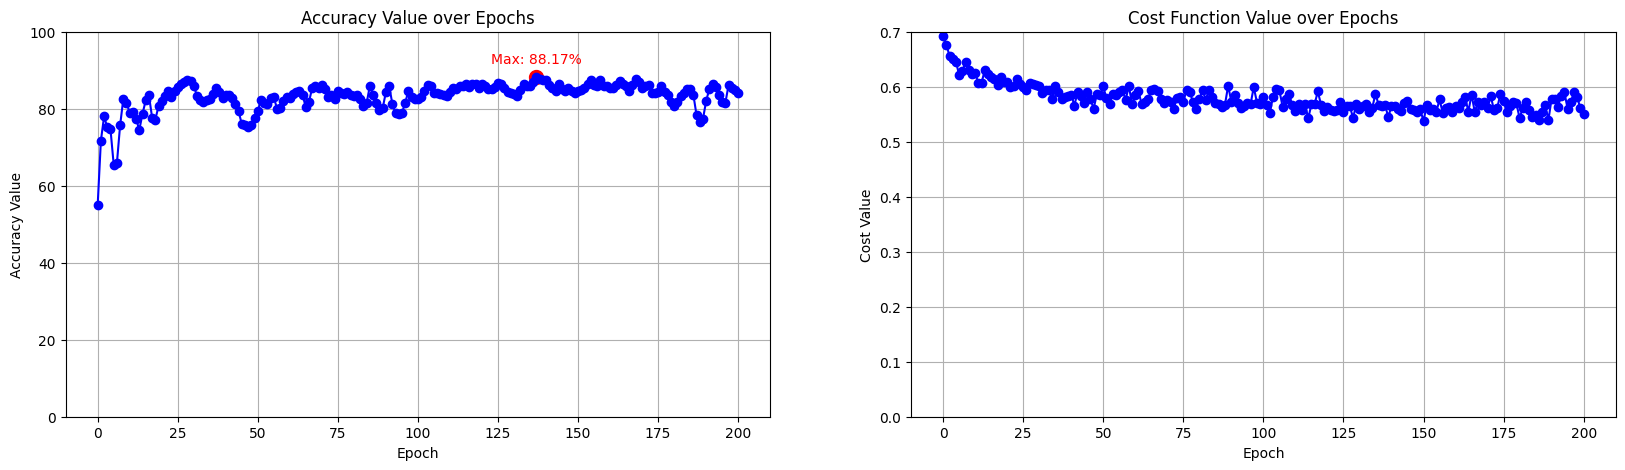

In [65]:
from Modules.Utils import plot_metrics_accuracy_and_cost
plot_metrics_accuracy_and_cost(all_accuracy,all_cost)

<a id="5"></a>
### Accuracy
* test_accuracy: 86,0%

In [66]:
# params giving maximum validation set accuracy
params_max_val_accuracy = all_params[np.argmax(all_accuracy)]
params_max_val_accuracy

tensor([[ 0.61506972, -0.21914414,  0.29168449, -0.41812503,  1.27929944,
          0.27942041,  1.02684831,  1.03516494,  1.29613612,  0.9792148 ,
         -0.0820213 ,  0.66387405, -0.289872  ,  0.69214558,  0.57334559],
        [ 0.22284137,  0.55355522, -0.21746391,  1.03754141,  0.96052537,
          0.9876715 ,  0.27397532,  1.35271362,  0.49499517, -0.21769281,
          1.02979292,  0.07262046,  1.21501454,  0.92345513,  0.19219041],
        [ 1.18810046,  1.55955113,  0.80517835,  0.22738696,  0.5770737 ,
          0.23539226,  0.98958571,  1.16347912, -0.45511007,  0.87053405,
         -0.28037768,  0.50560054,  0.62986818,  1.2397566 ,  0.4829161 ],
        [-0.18063772, -0.43341528, -0.10633471,  0.10557158,  0.79083128,
          0.10103335,  0.55283195,  1.39237111,  0.66406108,  0.42585887,
          0.55858627,  1.11110605,  0.07315144,  0.31772439,  1.17944634],
        [ 0.88398952,  0.41660841,  0.74308697,  0.64301948,  0.06974462,
         -0.15757566,  1.01724043,

In [67]:
test_accuracy = accuracy(params,encoded_X_test,Y_test,circuit_MERA)

Test accuracy calculated using the last params

In [68]:
test_accuracy

85.5

In [69]:
test_accuracy_max = accuracy(params_max_val_accuracy,encoded_X_test,Y_test,circuit_MERA)

Test accuracy calculated using the params that gave maximum validation set accuracy

In [70]:
test_accuracy_max

86.0

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = []
for i in range(len(X_test)):
    y_pred.append(np.argmax(circuit_MERA(encoded_X_test[i], params_max_val_accuracy)))
y_pred

[1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,


In [72]:
list(Y_test)

[tensor(1, requires_grad=True),
 tensor(0, requires_grad=True),
 tensor(1, requires_grad=True),
 tensor(0, requires_grad=True),
 tensor(0, requires_grad=True),
 tensor(1, requires_grad=True),
 tensor(1, requires_grad=True),
 tensor(1, requires_grad=True),
 tensor(1, requires_grad=True),
 tensor(0, requires_grad=True),
 tensor(0, requires_grad=True),
 tensor(1, requires_grad=True),
 tensor(0, requires_grad=True),
 tensor(0, requires_grad=True),
 tensor(0, requires_grad=True),
 tensor(1, requires_grad=True),
 tensor(1, requires_grad=True),
 tensor(1, requires_grad=True),
 tensor(1, requires_grad=True),
 tensor(0, requires_grad=True),
 tensor(1, requires_grad=True),
 tensor(0, requires_grad=True),
 tensor(0, requires_grad=True),
 tensor(0, requires_grad=True),
 tensor(0, requires_grad=True),
 tensor(0, requires_grad=True),
 tensor(0, requires_grad=True),
 tensor(0, requires_grad=True),
 tensor(1, requires_grad=True),
 tensor(1, requires_grad=True),
 tensor(0, requires_grad=True),
 tensor(

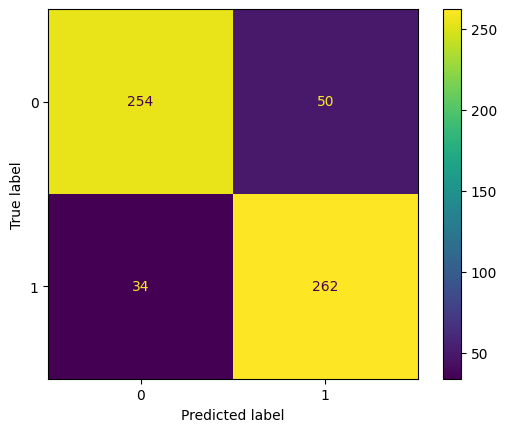

In [73]:
import matplotlib.pyplot as plt
cm = confusion_matrix(Y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

In [74]:
from sklearn.metrics import f1_score
f1_score(Y_test, y_pred, average=None)

array([0.85810811, 0.86184211])

The following cells in experiment 1 are for storing the results, they can be simply ignored if not needed.

In [75]:
#with open(r'C:/Users/lenovo/Desktop/DesktopAll/womanium/project/solution/QML-for-Conspicuity-Detection-in-Production/Task_5/Experiment output/qubits8_cross_entropy_1.txt', 'w') as fp:
#    fp.write('Experiment 1: \n')
#    for t, pred in zip(Y_test, y_pred):
#        # write each item on a new line
#        fp.write(str((t, pred)) + '\n')
#    print('Done')

Done


In [76]:
#y_pred_last = []
#for i in range(len(encoded_X_test)):
#    y_pred_last.append(np.argmax(circuit_MERA(encoded_X_test[i], params)))
#y_pred_last

[1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,


In [77]:
#with open(r'C:/Users/lenovo/Desktop/DesktopAll/womanium/project/solution/QML-for-Conspicuity-Detection-in-Production/Task_5/Experiment output/qubits8_cross_entropy_2.txt', 'w') as fp:
#    fp.write('Experiment 1: \n')
#    for t, pred_last in zip(Y_test, y_pred_last):
#        # write each item on a new line
#        fp.write(str((t, pred_last)) + '\n')
#    print('Done')

Done


<a id="6"></a>
### Experiments 2
<a id="7"></a>
#### Training
* Training set: [2393 2407]
* Validation set: [303 297]
* Test set: [304 296]
* Cost function: Exponential Loss
* Epoch: 100
* batch: 128
* learning rate:0.05
* val_accuracy: 92.67%

In [78]:
# training the circuit parameters
params = x2[:]
optimizer = qml.AdamOptimizer(stepsize=0.05)
batch_size = 128
all_params2 = []
all_cost2 = []
all_accuracy2 = []

In [79]:
start_time = time.time()

for k in range(201):
    batch_index = np.random.randint(0, len(encoded_X_train), (batch_size,))
    X_batch = encoded_X_train[batch_index]
    Y_batch = Y_train[batch_index]
    params, cost = optimizer.step_and_cost(costfunc_exponential, params, X=X_batch, Y=Y_batch, circuit = circuit_MERA, num_classes = 2)
    accuracy_value = accuracy(params,encoded_X_val,Y_val,circuit_MERA)
    print(f"Step {k}| Cost: {cost} | Validation accuracy: {accuracy_value:.2f}%")

    all_accuracy2.append(accuracy_value)
    all_cost2.append(cost)
    all_params2.append(params)
print(params)
print("--- %hr --- %", (time.time() - start_time)/3600)

Step 0| Cost: 0.4070454245272352 | Validation accuracy: 48.83%
Step 1| Cost: 0.4016546515024067 | Validation accuracy: 61.67%
Step 2| Cost: 0.3741254367252094 | Validation accuracy: 53.67%
Step 3| Cost: 0.400655399759624 | Validation accuracy: 69.50%
Step 4| Cost: 0.362147746201422 | Validation accuracy: 68.50%
Step 5| Cost: 0.3563782268379245 | Validation accuracy: 69.50%
Step 6| Cost: 0.34643540545286056 | Validation accuracy: 71.50%
Step 7| Cost: 0.33304413486752893 | Validation accuracy: 73.83%
Step 8| Cost: 0.3406786203462617 | Validation accuracy: 74.17%
Step 9| Cost: 0.3177929845328838 | Validation accuracy: 74.33%
Step 10| Cost: 0.32556688935593536 | Validation accuracy: 79.00%
Step 11| Cost: 0.32303967995763516 | Validation accuracy: 80.00%
Step 12| Cost: 0.31666265860676895 | Validation accuracy: 80.00%
Step 13| Cost: 0.32050565317810925 | Validation accuracy: 79.00%
Step 14| Cost: 0.30238221582057795 | Validation accuracy: 77.33%
Step 15| Cost: 0.3190231977449356 | Validatio

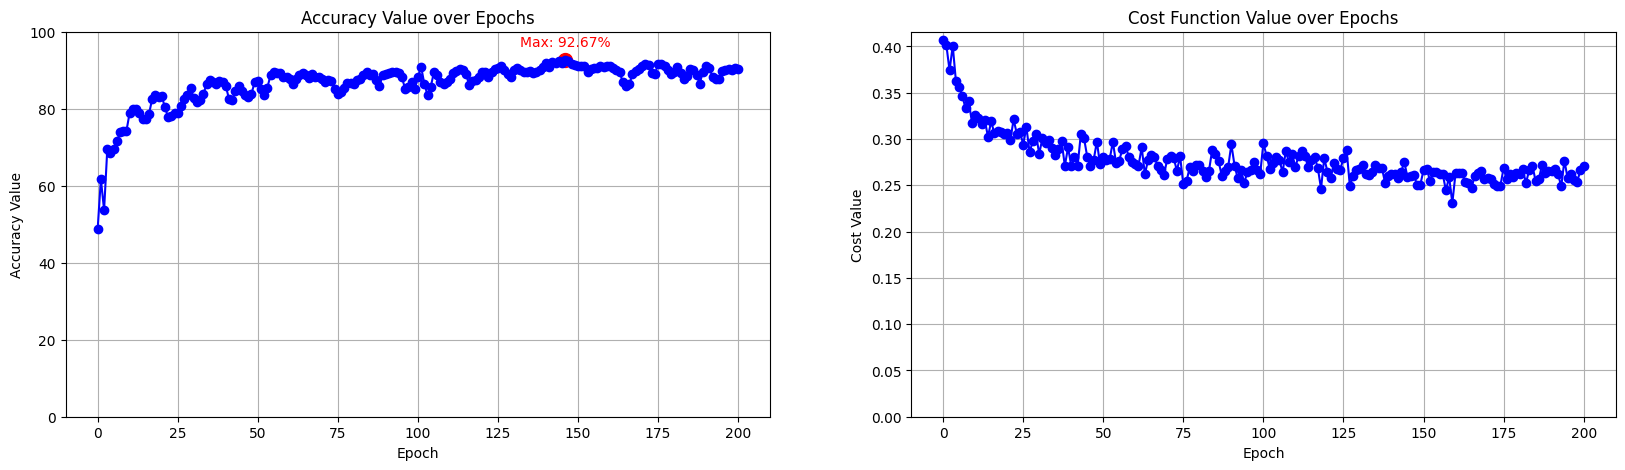

In [80]:
from Modules.Utils import plot_metrics_accuracy_and_cost
plot_metrics_accuracy_and_cost(all_accuracy2,all_cost2)

<a id="8"></a>
### Accuracy
* test_accuracy: 89.83%

In [81]:
# params giving maximum validation set accuracy
params_max_val_accuracy = all_params2[np.argmax(all_accuracy2)]
params_max_val_accuracy

tensor([[-1.60598106e-01,  4.84488155e-01,  2.60572436e-01,
          1.11498711e+00,  8.85640914e-01,  1.44762902e+00,
          1.42191981e+00,  3.67629851e-01,  1.46161254e+00,
          8.60912532e-01,  6.08961432e-01,  6.52698746e-01,
          4.20617709e-01,  5.26985337e-01,  7.32634527e-01],
        [ 7.51611368e-01, -5.46895631e-02,  3.90126705e-01,
          3.90327574e-01,  8.25330747e-01,  1.28103275e+00,
          2.80135495e-01,  1.45940622e+00,  6.21872071e-01,
         -1.18435883e-01,  1.59341732e-01,  5.86940614e-02,
          4.65013212e-01,  6.36634425e-01,  1.21552118e-01],
        [ 1.50916979e-01,  1.40180200e+00,  8.78179458e-01,
          2.21724996e-01,  5.74109274e-01,  7.35262192e-01,
          8.67029261e-01,  1.30850787e+00, -2.61159752e-01,
          6.03913710e-01, -3.20874962e-01,  3.13627130e-01,
          3.41739597e-01,  1.13201732e+00,  2.90783154e-01],
        [-2.61908559e-01,  1.97844312e-01, -3.78643550e-01,
          1.64854530e-01,  4.66048950

In [82]:
test_accuracy2 = accuracy(params,encoded_X_test,Y_test,circuit_MERA)

In [83]:
test_accuracy2

88.66666666666667

In [84]:
test_accuracy_max2 = accuracy(params_max_val_accuracy,encoded_X_test,Y_test,circuit_MERA)

In [85]:
test_accuracy_max2

89.83333333333333

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = []
for i in range(len(X_test)):
    y_pred.append(np.argmax(circuit_MERA(encoded_X_test[i], params_max_val_accuracy)))
y_pred

[1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,


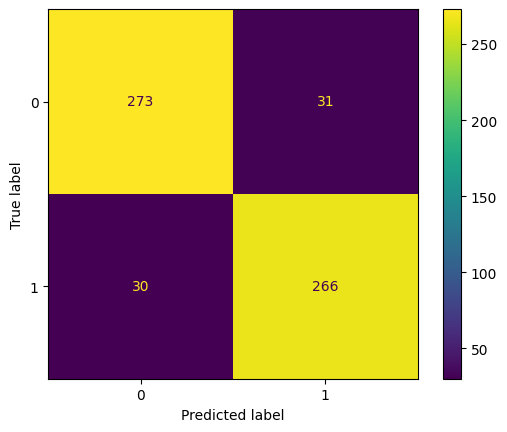

In [88]:
import matplotlib.pyplot as plt
cm = confusion_matrix(Y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

In [89]:
from sklearn.metrics import f1_score
f1_score(Y_test, y_pred, average=None)

array([0.89950577, 0.89713322])

The following cells in experiment 2 are for storing the results, they can be simply ignored if not needed.

In [90]:
#with open(r'C:/Users/lenovo/Desktop/DesktopAll/womanium/project/solution/QML-for-Conspicuity-Detection-in-Production/Task_5/Experiment output/qubits8_exponential_loss_1.txt', 'w') as fp:
#    fp.write('Experiment 2: \n')
#    for t, pred in zip(Y_test, y_pred):
#        # write each item on a new line
#        fp.write(str((t, pred)) + '\n')
#    print('Done')

Done


In [91]:
#y_pred_last = []
#for i in range(len(X_test)):
#    y_pred_last.append(np.argmax(circuit_MERA(encoded_X_test[i], params)))
#y_pred_last

[1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,


In [93]:
#with open(r'C:/Users/lenovo/Desktop/DesktopAll/womanium/project/solution/QML-for-Conspicuity-Detection-in-Production/Task_5/Experiment output/qubits8_exponential_loss_2.txt', 'w') as fp:
#    fp.write('Experiment 2: \n')
#    for t, pred_last in zip(Y_test, y_pred_last):
#        # write each item on a new line
#        fp.write(str((t, pred_last)) + '\n')
#    print('Done')

Done


<a id="9"></a>
### Experiments 3
<a id="10"></a>
#### Training
* Training set: [2393 2407]
* Validation set: [303 297]
* Test set: [304 296]
* Cost function: Focal Loss(gamma = 1)
* Epoch: 100
* batch: 128
* learning rate:0.05
* val_accuracy: 89,33%

In [95]:
# training the circuit parameters
params = x2[:]
optimizer = qml.AdamOptimizer(stepsize=0.05)
batch_size = 128
all_params3 = []
all_cost3 = []
all_accuracy3 = []

In [96]:
start_time = time.time()

for k in range(201):
    batch_index = np.random.randint(0, len(encoded_X_train), (batch_size,))
    X_batch = encoded_X_train[batch_index]
    Y_batch = Y_train[batch_index]
    params, cost = optimizer.step_and_cost(costfunc_focal, params, X=X_batch, Y=Y_batch, circuit = circuit_MERA, num_classes = 2, gamma = 1)
    accuracy_value = accuracy(params,encoded_X_val,Y_val,circuit_MERA)
    print(f"Step {k}| Cost: {cost} | Validation accuracy: {accuracy_value:.2f}%")

    all_accuracy3.append(accuracy_value)
    all_cost3.append(cost)
    all_params3.append(params)
print(params)
print("--- %hr --- %", (time.time() - start_time)/3600)

Step 0| Cost: 0.3433768976040672 | Validation accuracy: 54.17%
Step 1| Cost: 0.3322654780702609 | Validation accuracy: 75.67%
Step 2| Cost: 0.3205729538681844 | Validation accuracy: 62.83%
Step 3| Cost: 0.32339791961108805 | Validation accuracy: 73.50%
Step 4| Cost: 0.3115763349685361 | Validation accuracy: 80.33%
Step 5| Cost: 0.30743358911494667 | Validation accuracy: 76.17%
Step 6| Cost: 0.3059331005898665 | Validation accuracy: 79.67%
Step 7| Cost: 0.3034188648553819 | Validation accuracy: 80.83%
Step 8| Cost: 0.2969606810082852 | Validation accuracy: 79.50%
Step 9| Cost: 0.2946525340116079 | Validation accuracy: 81.00%
Step 10| Cost: 0.28755639975147324 | Validation accuracy: 80.00%
Step 11| Cost: 0.2964424179340901 | Validation accuracy: 80.17%
Step 12| Cost: 0.28709206871891535 | Validation accuracy: 81.00%
Step 13| Cost: 0.29192203481345486 | Validation accuracy: 81.83%
Step 14| Cost: 0.2841323207424727 | Validation accuracy: 82.83%
Step 15| Cost: 0.28325630471984975 | Validati

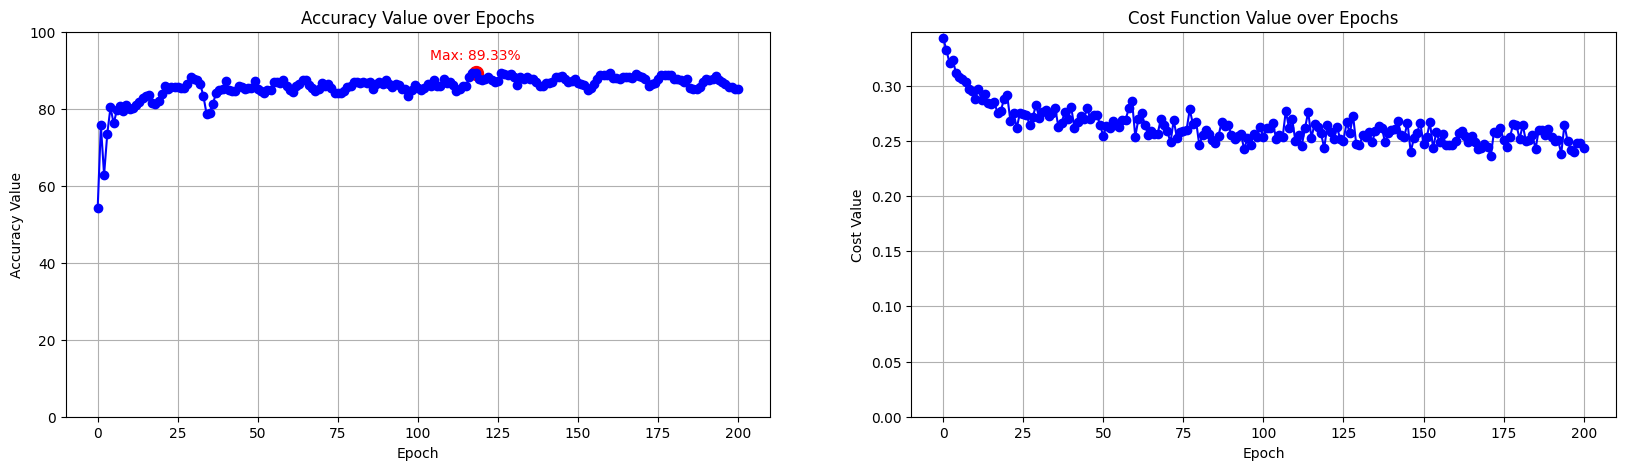

In [98]:
from Modules.Utils import plot_metrics_accuracy_and_cost
plot_metrics_accuracy_and_cost(all_accuracy3,all_cost3)

<a id="11"></a>
### Accuracy
* test_accuracy: 86,0%

In [99]:
# params giving maximum validation set accuracy
params_max_val_accuracy = all_params3[np.argmax(all_accuracy3)]
params_max_val_accuracy

tensor([[ 0.34171124,  0.63775561,  0.08197604,  0.56075378,  1.10214131,
          0.17938242,  1.09565898,  1.25279741,  0.8692226 ,  0.96410337,
          0.36046647,  0.83273714,  0.11838817,  1.20068986,  0.34910816],
        [ 0.62396421,  0.89024164, -0.11183649,  0.84253147,  0.6589282 ,
          0.4267557 ,  0.18705105,  1.30209722,  0.67379987,  0.35418775,
          0.21150932,  0.40336894,  0.96772265,  0.1326231 , -0.05154491],
        [-0.89517066,  1.7329645 ,  0.84423978,  0.19963425,  0.67176555,
          1.10440169,  1.08828767,  0.98515987,  0.92757202,  0.64588852,
         -0.64248611,  0.27951312,  0.35256   ,  1.6129601 ,  0.10958693],
        [-0.01540978,  0.54635742,  0.20757849,  0.15347131,  0.03906413,
         -0.00371975,  0.71174061,  0.57195154,  0.72899272,  0.09561424,
          1.09430007,  0.85012137, -0.05427705,  0.39860181,  1.14342063],
        [ 0.6402542 ,  0.10288112,  0.51383016,  0.81188257, -0.02167114,
          0.15773953,  0.024196  ,

In [100]:
test_accuracy3 = accuracy(params,encoded_X_test,Y_test,circuit_MERA)

In [101]:
test_accuracy3

86.66666666666667

In [102]:
test_accuracy_max3 = accuracy(params_max_val_accuracy,encoded_X_test,Y_test,circuit_MERA)

In [103]:
test_accuracy_max3

86.0

In [104]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = []
for i in range(len(X_test)):
    y_pred.append(np.argmax(circuit_MERA(encoded_X_test[i], params_max_val_accuracy)))
y_pred

[1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,


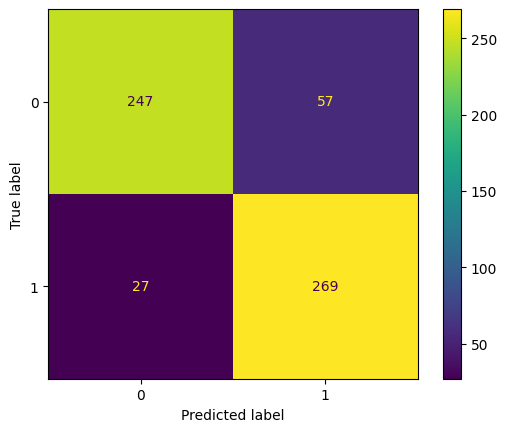

In [105]:
import matplotlib.pyplot as plt
cm = confusion_matrix(Y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

In [106]:
from sklearn.metrics import f1_score
f1_score(Y_test, y_pred, average=None)

array([0.85467128, 0.86495177])

The following cells in experiment 3 are for storing the results, they can be simply ignored if not needed.

In [107]:
#with open(r'C:/Users/lenovo/Desktop/DesktopAll/womanium/project/solution/QML-for-Conspicuity-Detection-in-Production/Task_5/Experiment output/qubits8_gamma1_focal_loss_1.txt', 'w') as fp:
#    fp.write('Experiment 3: \n')
#    for t, pred in zip(Y_test, y_pred):
#        # write each item on a new line
#        fp.write(str((t, pred)) + '\n')
#    print('Done')

Done


In [108]:
#y_pred_last = []
#for i in range(len(X_test)):
#    y_pred_last.append(np.argmax(circuit_MERA(encoded_X_test[i], params)))
#y_pred_last

[1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,


In [109]:
#with open(r'C:/Users/lenovo/Desktop/DesktopAll/womanium/project/solution/QML-for-Conspicuity-Detection-in-Production/Task_5/Experiment output/qubits8_gamma1_focal_loss_2.txt', 'w') as fp:
#    fp.write('Experiment 3: \n')
#    for t, pred_last in zip(Y_test, y_pred_last):
#        # write each item on a new line
#        fp.write(str((t, pred_last)) + '\n')
#    print('Done')

Done


<a id="12"></a>
### Experiments 4
<a id="13"></a>
#### Training
* Training set: [2393 2407]
* Validation set: [303 297]
* Test set: [304 296]
* Cost function: Focal Loss(gamma = 2)
* Epoch: 100
* batch: 128
* learning rate:0.05
* val_accuracy: 92.33%

In [111]:
# training the circuit parameters
from pennylane import numpy as np
params = x2[:]
optimizer = qml.AdamOptimizer(stepsize=0.05)
batch_size = 128
all_params4 = []
all_cost4 = []
all_accuracy4 = []

In [112]:
start_time = time.time()

for k in range(201):
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = encoded_X_train[batch_index]
    Y_batch = Y_train[batch_index]
    params, cost = optimizer.step_and_cost(costfunc_focal, params, X=X_batch, Y=Y_batch, circuit = circuit_MERA, num_classes = 2, gamma = 2)
    accuracy_value = accuracy(params,encoded_X_val,Y_val,circuit_MERA)
    print(f"Step {k}| Cost: {cost} | Validation accuracy: {accuracy_value:.2f}%")

    all_accuracy4.append(accuracy_value)
    all_cost4.append(cost)
    all_params4.append(params)
print(params)
print("--- %hr --- %", (time.time() - start_time)/3600)

Step 0| Cost: 0.1797404425545177 | Validation accuracy: 63.33%
Step 1| Cost: 0.15894539065820326 | Validation accuracy: 76.50%
Step 2| Cost: 0.15391715483366825 | Validation accuracy: 75.83%
Step 3| Cost: 0.1467970086559661 | Validation accuracy: 79.83%
Step 4| Cost: 0.1437333570887056 | Validation accuracy: 73.50%
Step 5| Cost: 0.15001834780041867 | Validation accuracy: 80.17%
Step 6| Cost: 0.14221704850961364 | Validation accuracy: 81.33%
Step 7| Cost: 0.1418191914892701 | Validation accuracy: 81.83%
Step 8| Cost: 0.13609617002830002 | Validation accuracy: 82.17%
Step 9| Cost: 0.13592709978520034 | Validation accuracy: 79.33%
Step 10| Cost: 0.13683572785674097 | Validation accuracy: 77.00%
Step 11| Cost: 0.13796984320725703 | Validation accuracy: 77.83%
Step 12| Cost: 0.13130525080655892 | Validation accuracy: 80.67%
Step 13| Cost: 0.13018613316321742 | Validation accuracy: 83.00%
Step 14| Cost: 0.13797393802087085 | Validation accuracy: 83.83%
Step 15| Cost: 0.13028307458207602 | Va

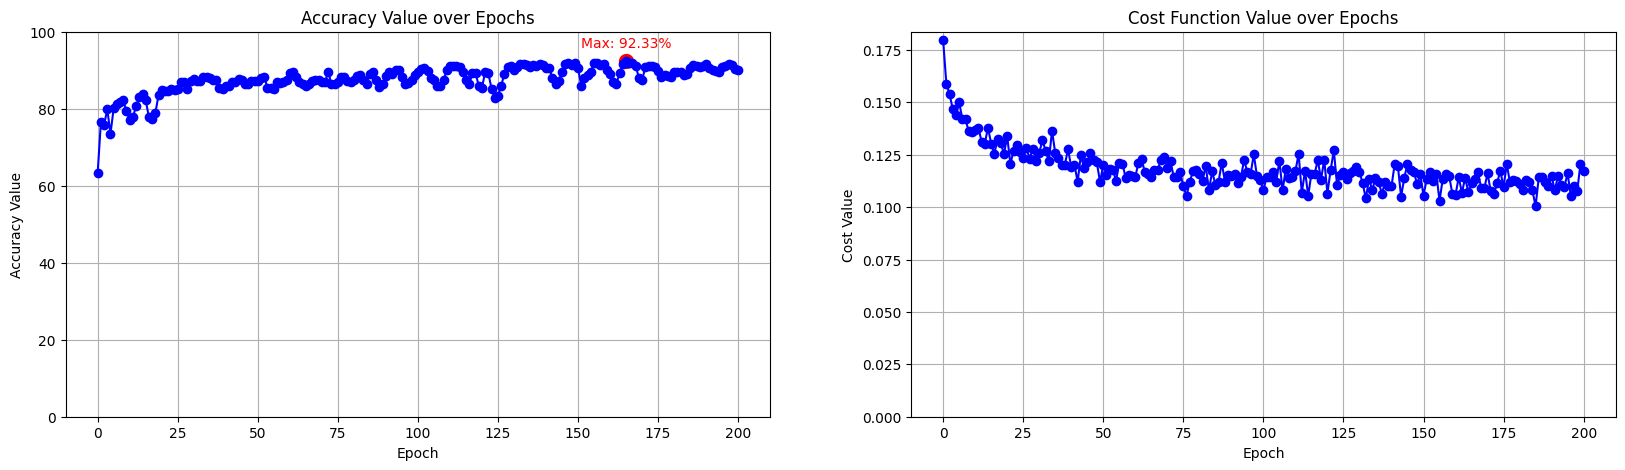

In [114]:
from Modules.Utils import plot_metrics_accuracy_and_cost
plot_metrics_accuracy_and_cost(all_accuracy4,all_cost4)

<a id="14"></a>
### Accuracy
* test_accuracy: 80.83% 

In [115]:
# params giving maximum validation set accuracy
params_max_val_accuracy = all_params[np.argmax(all_accuracy4)]
params_max_val_accuracy

tensor([[ 6.41330493e-01, -1.76206376e-01,  2.75753579e-01,
         -3.96831903e-01,  1.27558267e+00,  3.42550187e-01,
          1.10278921e+00,  1.03503267e+00,  1.33872281e+00,
          9.77949391e-01,  1.68981244e-02,  6.52235620e-01,
         -1.93295437e-01,  6.99655223e-01,  6.36761025e-01],
        [ 1.61162070e-01,  5.37680203e-01, -5.23008431e-02,
          9.81905369e-01,  8.65545284e-01,  9.98938864e-01,
          3.24694073e-01,  1.28412906e+00,  5.18006714e-01,
         -2.71794856e-01,  1.06115382e+00,  6.03336192e-04,
          1.21173051e+00,  9.94177372e-01,  1.89717037e-01],
        [ 1.08144112e+00,  1.63920588e+00,  7.70635374e-01,
          2.49062250e-01,  5.95618697e-01,  2.15276131e-01,
          9.47441924e-01,  1.07272765e+00, -3.93949928e-01,
          8.32426372e-01, -3.02963506e-01,  4.57917282e-01,
          5.53803912e-01,  1.19542454e+00,  4.77847660e-01],
        [-2.15591094e-01, -5.06089362e-01, -3.62982009e-02,
          9.02707966e-02,  9.16738520

In [116]:
test_accuracy4 = accuracy(params,encoded_X_test,Y_test,circuit_MERA)

In [117]:
test_accuracy4

87.16666666666667

In [118]:
test_accuracy_max4 = accuracy(params_max_val_accuracy,encoded_X_test,Y_test,circuit_MERA)

In [119]:
test_accuracy_max4

80.83333333333333

In [120]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = []
for i in range(len(X_test)):
    y_pred.append(np.argmax(circuit_MERA(encoded_X_test[i], params_max_val_accuracy)))
y_pred

[1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,


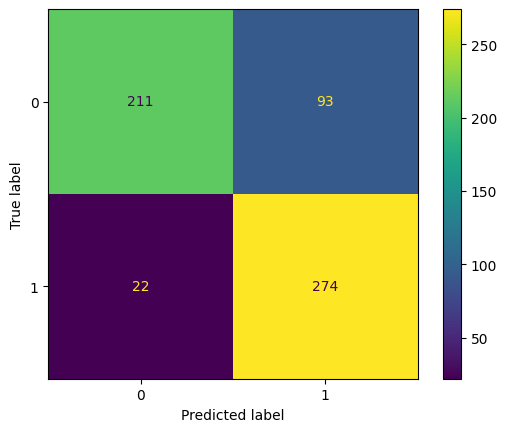

In [121]:
import matplotlib.pyplot as plt
cm = confusion_matrix(Y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

In [122]:
from sklearn.metrics import f1_score
f1_score(Y_test, y_pred, average=None)

array([0.7858473, 0.826546 ])

The following cells in experiment 4 are for storing the results, they can be simply ignored if not needed.

In [123]:
#with open(r'C:/Users/lenovo/Desktop/DesktopAll/womanium/project/solution/QML-for-Conspicuity-Detection-in-Production/Task_5/Experiment output/qubits8_gamma2_focal_loss_1.txt', 'w') as fp:
#    fp.write('Experiment 4: \n')
#    for t, pred in zip(Y_test, y_pred):
#        # write each item on a new line
#        fp.write(str((t, pred)) + '\n')
#    print('Done')

Done


In [124]:
#y_pred_last = []
#for i in range(len(X_test)):
#    y_pred_last.append(np.argmax(circuit_MERA(encoded_X_test[i], params)))
#y_pred_last

[1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,


In [125]:
#with open(r'C:/Users/lenovo/Desktop/DesktopAll/womanium/project/solution/QML-for-Conspicuity-Detection-in-Production/Task_5/Experiment output/qubits8_gamma2_focal_loss_2.txt', 'w') as fp:
#    fp.write('Experiment 4: \n')
#    for t, pred_last in zip(Y_test, y_pred_last):
#        # write each item on a new line
#        fp.write(str((t, pred_last)) + '\n')
#    print('Done')

Done
